<a href="https://colab.research.google.com/github/fadingNA/Emotion-Recogntion/blob/main/Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
# Import libraries for data manipulation, visualization and warnings
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random

# Import tensorflow and keras for deep learning tools
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.image import load_img, img_to_array
from keras.models import Sequential
from keras.layers import (
    Input,
    Dense,
    Conv2D,
    Dropout,
    Flatten,
    MaxPooling2D,
    BatchNormalization,
    Activation,
    LeakyReLU,
    GlobalAveragePooling2D,
)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

NUM_CLASSES = 7
TARGET_SIZE = (48, 48)  # Target image size for resizing
INPUT_SHAPE = (48, 48, 1)  # grayscale image

In [16]:
# Import kagglehub to download datasets from Kaggle
import kagglehub

# Download FER2013 dataset from Kaggle (didplay path for referrence)
path = kagglehub.dataset_download("msambare/fer2013")
print("Path to dataset files:", path)

100%|██████████| 60.3M/60.3M [00:03<00:00, 16.8MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/msambare/fer2013/versions/1


In [17]:
# Import shutil library for file operations
import shutil

# Define source and destination paths for dataset
source = "/root/.cache/kagglehub/datasets/msambare/fer2013/versions/1"
destination = "/content/dataset"

# Move dataset files from source to destination folder (display where moved to for referrence)
shutil.move(source, destination)
print(f"Files moved to {destination}")

Files moved to /content/dataset


In [31]:
# Define the paths for training and testing directories
TRAIN_DIR = './dataset/train'
TEST_DIR = './dataset/test'

In [32]:
# Display the contents of the dataset directories
print(os.listdir(TRAIN_DIR))
print(os.listdir(TEST_DIR))
print(len(os.listdir(TRAIN_DIR+'/angry')))
print(len(os.listdir(TRAIN_DIR+'/disgust')))

['disgust', 'angry', 'sad', 'fear', 'happy', 'neutral', 'surprise']
['disgust', 'angry', 'sad', 'fear', 'happy', 'neutral', 'surprise']
3995
436


In [33]:
# Function to load the dataset images and their labels
def load_dataset(directory):
    image_paths = []  # List for storing image paths
    labels = []       # List for storing labels

    # Iterate through each label in the dataset directory
    for label in os.listdir(directory):
        label_path = os.path.join(directory, label)  # Use os.path.join to create label path
        if not os.path.isdir(label_path):  # Skip if it's not a directory
            continue

        # Iterate through the images within the label directory
        for filename in os.listdir(label_path):
            if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.tiff', '.bmp', '.gif')):
                image_path = os.path.join(label_path, filename)
                image_paths.append(image_path)  # Append image path
                labels.append(label)            # Append label

        # Display completion validation
        print(label, "Completed")

    return image_paths, labels

In [34]:
# Convert training dataset into a DataFrame
train = pd.DataFrame()
train['image'], train['label'] = load_dataset(TRAIN_DIR)

# Mix up the training dataset
# set seed for reproducibility
train = train.sample(frac=1, random_state=42).reset_index(drop=True)
train.head()


test = pd.DataFrame()
test['image'], test['label'] = load_dataset(TEST_DIR)
test = test.sample(frac=1, random_state=42).reset_index(drop=True)
test.head()

disgust Completed
angry Completed
sad Completed
fear Completed
happy Completed
neutral Completed
surprise Completed
disgust Completed
angry Completed
sad Completed
fear Completed
happy Completed
neutral Completed
surprise Completed


,image,label
0,./dataset/test/happy/PrivateTest_89942126.jpg,happy
1,./dataset/test/fear/PublicTest_77017947.jpg,fear
2,./dataset/test/happy/PrivateTest_7339158.jpg,happy
3,./dataset/test/neutral/PrivateTest_49660038.jpg,neutral
4,./dataset/test/sad/PrivateTest_70326538.jpg,sad


In [35]:
for label in os.listdir(TRAIN_DIR):
    label_path = os.path.join(TRAIN_DIR, label)
    if os.path.isdir(label_path):
        print(f"{label}: {len(os.listdir(label_path))} images")

disgust: 436 images
angry: 3995 images
sad: 4830 images
fear: 4097 images
happy: 7215 images
neutral: 4965 images
surprise: 3171 images


In [23]:
def get_features(image_paths, target_size=(48, 48), color_mode='grayscale'):
    img_features = []
    for image_path in image_paths:
        if not os.path.exists(image_path):
            import sys
            print(f"Image not found: {image_path}", file=sys.stderr)
            continue
        try:
            img = load_img(image_path, target_size=target_size, color_mode=color_mode)
            img = img_to_array(img) / 255.0  # Normalize
            img_features.append(img)
        except Exception as e:
            print(f"Error processing {image_path}: {e}")
    return np.array(img_features).reshape(-1, *target_size, 1)


In [36]:
def validate_features(features, target_shape=(48, 48, 1)):

    if features.shape[1:] != target_shape:
        print(f"Validation failed: Expected shape {target_shape}, but got {features.shape[1:]}.")
        return False

    if np.any(np.isnan(features)) or np.any(np.isinf(features)):
        print("Validation failed: Found NaN or infinite values in features.")
        return False

    if np.min(features) < 0.0 or np.max(features) > 1.0:
        print("Validation failed: Feature values are not in the range [0, 1].")
        return False

    print("Validation passed: All checks passed.")
    return True

In [38]:
# Extract the features from training and testing datasets
TARGET_SIZE = (48, 48)
train_features = get_features(train['image'],  target_size=TARGET_SIZE)
test_features = get_features(test['image'], target_size=TARGET_SIZE)

# validation of features train & test

if validate_features(train_features) and validate_features(test_features):
    print("Features validation passed.")
else:
    print("Features validation failed.")


Validation passed: All checks passed.
Validation passed: All checks passed.
Features validation passed.


In [44]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit the encoder to training labels
label_encoder.fit(train["label"])

# Transform both training and testing labels to integer values
# 0 to 6 for the 7 classes start from angry to neutral
y_train = label_encoder.transform(train["label"])
y_test = label_encoder.transform(test["label"])

# Convert integer labels to one-hot encoded vectors using Keras
# Dynamic exact number of classes
num_classes = len(label_encoder.classes_)

"""
To convert the integer labels to one-hot encoded vectors, we can use the to_categorical function from Keras.
This function takes the integer labels and the number of classes as input and returns the one-hot encoded vectors.
"""

y_train = to_categorical(y_train, num_classes=num_classes)
y_test = to_categorical(y_test, num_classes=num_classes)


# Output the one-hot encoded vectors and classes
print("One-hot encoded labels (first 5 rows):")
print(y_train[:5])
print("Classes:")
print(label_encoder.classes_)

One-hot encoded labels (first 5 rows):
[[0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1.]]
Classes:
['angry' 'disgust' 'fear' 'happy' 'neutral' 'sad' 'surprise']


In [45]:
x_train = train_features
x_test = test_features
print("x_train shape:", x_train.shape)
print("x_test shape:", x_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

x_train shape: (28709, 48, 48, 1)
x_test shape: (7178, 48, 48, 1)
y_train shape: (28709, 7)
y_test shape: (7178, 7)


In [46]:
# Build the CNN model
model = Sequential()
model.add(Input(shape=INPUT_SHAPE))

# First convolutional block
# - The 32 filters help the model learn 32 distinct patterns or features from the input data.
# - The kernel size (3x3) determines the receptive field used to scan the input.
# - ReLU (Rectified Linear Unit) activation introduces non-linearity to enable the model
#   to learn complex relationships between features.
# This layer extracts low-level features such as edges and textures from the input image.
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))

# Add a batch normalization layer immediately after the convolutional layer.
# - This layer normalizes the outputs of the convolutional layer to have a mean of 0
#   and a standard deviation of 1, which helps stabilize the learning process.
# - It reduces sensitivity to weight initialization and allows the model to train faster.
# Batch normalization also acts as a regularizer, reducing the chances of overfitting.
model.add(BatchNormalization())

# Second convolutional block
# - Increase filters to 64
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())

# - Add a max pooling layer with a pool size of 2x2.
# - This layer downsamples the spatial dimensions of the feature maps,
# - reducing computation and helping the model focus on dominant features.
model.add(MaxPooling2D(pool_size=(2, 2)))

# - Add a dropout layer with a dropout rate of 0.5.
# - This randomly sets 50% of the neurons to zero during training to prevent overfitting
# - and improve the generalization capability of the model.
model.add(Dropout(0.5))

# Third convolutional block
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

# Fourth convolutional block
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

# Fully connected layers
model.add(Flatten())  # Flatten feature maps

# - The large number of neurons (1024) provides the model with significant capacity
# - to learn intricate details in the data.
model.add(Dense(1024, activation='relu')) # Fully connected layer
model.add(Dropout(0.2)) # Dropout

# - Each neuron corresponds to one of the 7 emotion classes in the dataset.
# - The softmax activation function ensures that the output values represent probabilities
# - and sum to 1, making it suitable for multi-class classification tasks.
model.add(Dense(7, activation='softmax')) # Output layer

# Display the model summary
model.summary()

# Complie the model using Adam optimizer and categorical cross-entropy loss
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_20 (Conv2D)                   │ (None, 46, 46, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_14               │ (None, 46, 46, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_21 (Conv2D)                   │ (None, 44, 44, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_22 (Conv2D)                   │ (None, 42, 42, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_15               │ (None, 42, 42, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 21, 21, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 21, 21, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_23 (Conv2D)                   │ (None, 19, 19, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_24 (Conv2D)                   │ (None, 17, 17, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_16               │ (None, 17, 17, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_25 (Conv2D)                   │ (None, 6, 6, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_26 (Conv2D)                   │ (None, 4, 4, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_17               │ (None, 4, 4, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 2, 2, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ (None, 2, 2, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 1024)                │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 884,679 (3.37 MB)

 Trainable params: 884,103 (3.37 MB)

 Non-trainable params: 576 (2.25 KB)

In [47]:
model2 = Sequential()
model2.add(Input(shape=INPUT_SHAPE))

# Convolutional Input Layer
model2.add(Conv2D(32, kernel_size=(3, 3), padding="same", activation="relu"))
model2.add(BatchNormalization())
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.3))

# Convolutional HL 2
model2.add(Conv2D(64, kernel_size=(3, 3), padding="same", activation="relu"))
model2.add(BatchNormalization())
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.3))

# Convolutional HL 3
model2.add(Conv2D(128, kernel_size=(3, 3), padding="same", activation="relu"))
model2.add(BatchNormalization())
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.4))

# Global Average Pooling
model2.add(GlobalAveragePooling2D())
model2.add(Dense(64, activation="relu"))
model2.add(Dropout(0.3))

# Output Layer
model2.add(Dense(7, activation="softmax"))

# Compile the model
opti = Adam(learning_rate=0.0005)
model2.compile(optimizer=opti, loss="categorical_crossentropy", metrics=["accuracy"])
model2.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_27 (Conv2D)                   │ (None, 48, 48, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_18               │ (None, 48, 48, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (None, 24, 24, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_20 (Dropout)                 │ (None, 24, 24, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_28 (Conv2D)                   │ (None, 24, 24, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_19               │ (None, 24, 24, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_16 (MaxPooling2D)      │ (None, 12, 12, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_21 (Dropout)                 │ (None, 12, 12, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_29 (Conv2D)                   │ (None, 12, 12, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_20               │ (None, 12, 12, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_17 (MaxPooling2D)      │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_22 (Dropout)                 │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 128)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_23 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 7)                   │             455 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 102,279 (399.53 KB)

 Trainable params: 101,831 (397.78 KB)

 Non-trainable params: 448 (1.75 KB)

- Validation Loss Fluctuations:
- Validation loss fluctuates significantly (e.g., jumping from 1.8796 to 4.0646 and then back to 1.8438), indicating potential overfitting or instability in training.

- Drop in Performance in Later Epochs:
	•	After an initial improvement, performance metrics degrade in some epochs (e.g., validation loss increases to 3.9991 in epoch 5), possibly due to overfitting, inadequate regularization, or a mismatch in data preprocessing between training and validation datasets.

In [48]:
# Setup for early stopping and learning rate reduction callbacks
# - Callback stops training early if validation loss does not improve
# - within given number of epochs (50)
early_stopping = EarlyStopping("val_loss", patience=50)

# Define the ReduceLROnPlateau callback.
# - This reduces the learning rate when the validation loss stops improving.
# - `monitor='val_loss'`: Monitors the validation loss during training.
# - `factor=0.1`: Reduces the learning rate by a factor of 10 when triggered.
# - `patience=int(50/4)`: Waits for approximately 12 epochs (1/4 of `patience` for early stopping) without improvement before reducing the learning rate.
# - `verbose=1`: Logs messages to the console when the learning rate is reduced.
reduce_lr = ReduceLROnPlateau("val_loss", factor=0.1, patience=int(50 / 4), verbose=1)

# Train the model
# - `x=x_train, y=y_train`: The training data and corresponding labels.
# - `batch_size=64`: Specifies the number of training samples processed before the model updates.
# - `epochs=40`: The maximum number of times the entire training dataset is processed.
# - `verbose=1`: Displays detailed progress information during training.
# - `validation_data=(x_test, y_test)`: Specifies the validation dataset for monitoring validation performance.
# - `callbacks=[early_stopping, reduce_lr]`: Adds the early stopping and learning rate reduction callbacks
# - to dynamically manage training termination and learning rate adjustments.

if len(train_features) != len(y_train):
    print("Length of train_features and y_train are not equal")
else:
    model_info = model.fit(
        x=x_train,
        y=y_train,
        epochs=40, # 40 epochs finer tuning
        batch_size=128,
        verbose=1, # display progress
        validation_data=(x_test, y_test),
        callbacks=[early_stopping, reduce_lr],
    )

Epoch 1/40
225/225 ━━━━━━━━━━━━━━━━━━━━ 34s 88ms/step - accuracy: 0.2507 - loss: 2.0871 - val_accuracy: 0.1722 - val_loss: 2.2679 - learning_rate: 0.0010
Epoch 2/40
225/225 ━━━━━━━━━━━━━━━━━━━━ 21s 43ms/step - accuracy: 0.3887 - loss: 1.5654 - val_accuracy: 0.3193 - val_loss: 1.7043 - learning_rate: 0.0010
Epoch 3/40
225/225 ━━━━━━━━━━━━━━━━━━━━ 10s 43ms/step - accuracy: 0.4478 - loss: 1.4284 - val_accuracy: 0.4710 - val_loss: 1.3912 - learning_rate: 0.0010
Epoch 4/40
225/225 ━━━━━━━━━━━━━━━━━━━━ 10s 43ms/step - accuracy: 0.4774 - loss: 1.3468 - val_accuracy: 0.4692 - val_loss: 1.4621 - learning_rate: 0.0010
Epoch 5/40
225/225 ━━━━━━━━━━━━━━━━━━━━ 10s 43ms/step - accuracy: 0.5032 - loss: 1.2854 - val_accuracy: 0.5219 - val_loss: 1.2654 - learning_rate: 0.0010
Epoch 6/40
225/225 ━━━━━━━━━━━━━━━━━━━━ 10s 43ms/step - accuracy: 0.5272 - loss: 1.2272 - val_accuracy: 0.5344 - val_loss: 1.2111 - learning_rate: 0.0010
Epoch 7/40
225/225 ━━━━━━━━━━━━━━━━━━━━ 9s 42ms/step - accuracy: 0.5480 - lo

In [51]:
model_info2 = model2.fit(
    x=x_train,
    y=y_train,
    epochs=20,
    verbose=1,
    batch_size=128,
    validation_data=(x_test, y_test),
    callbacks=[early_stopping, reduce_lr],
)

Epoch 1/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.2676 - loss: 1.7763 - val_accuracy: 0.1773 - val_loss: 2.2485 - learning_rate: 5.0000e-04
Epoch 2/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.2952 - loss: 1.7322 - val_accuracy: 0.2940 - val_loss: 1.7336 - learning_rate: 5.0000e-04
Epoch 3/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.3449 - loss: 1.6491 - val_accuracy: 0.3683 - val_loss: 1.5788 - learning_rate: 5.0000e-04
Epoch 4/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.3835 - loss: 1.5753 - val_accuracy: 0.4185 - val_loss: 1.5016 - learning_rate: 5.0000e-04
Epoch 5/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.4114 - loss: 1.5208 - val_accuracy: 0.3913 - val_loss: 1.6266 - learning_rate: 5.0000e-04
Epoch 6/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.4322 - loss: 1.4705 - val_accuracy: 0.4543 - val_loss: 1.4312 - learning_rate: 5.0000e-04
Epoch 7/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - acc

In [52]:
# Evaluate the accuracy
loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
print(f"Model 1: Test loss: {loss:.4f}, accuracy: {accuracy:.4f}")

loss2, accuracy2 = model2.evaluate(x_test, y_test, verbose=0)
print(f"Model 2: Test loss: {loss2:.4f}, accuracy: {accuracy2:.4f}")


Model 1: Test loss: 1.0770, accuracy: 0.6421
Model 2: Test loss: 1.1854, accuracy: 0.5439


In [53]:
# Save the model structure and weights
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

model_json2 = model2.to_json()
with open("model2.json", "w") as json:
    json.write(model_json2)

In [54]:
# Save the trained model weight in .h5 file
model.save_weights('model.weights.h5')
model2.save_weights('model2.weights.h5')

In [56]:
# Save the complete model in .keras format
model.save("finalmodel.keras")
model2.save("finalmodel2.keras")


In [58]:
# Plot the training accuracy and loss graphs
accuracy = model_info.history['accuracy']
val_accuracy = model_info.history['val_accuracy']
loss = model_info.history['loss']
val_loss = model_info.history['val_loss']

accuracy2 = model_info2.history['accuracy']  # Training accuracy for Model 2
val_accuracy2 = model_info2.history['val_accuracy']  # Validation accuracy for Model 2
loss2 = model_info2.history['loss']  # Training loss for Model 2
val_loss2 = model_info2.history['val_loss']  # Validation loss for Model 2

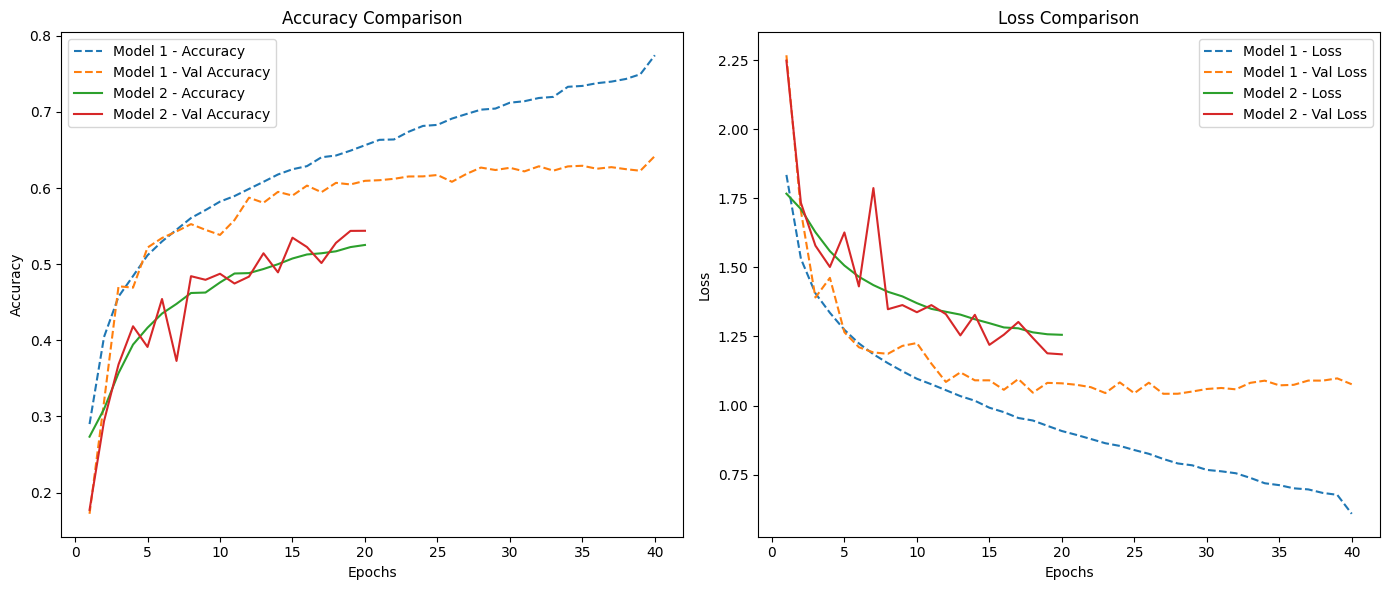

In [60]:

# Plot accuracy comparison
plt.figure(figsize=(14, 6))
epochs = range(1, len(accuracy) + 1)
epochs2 = range(1, len(accuracy2) + 1)

plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, label='Model 1 - Accuracy', linestyle='--')
plt.plot(epochs, val_accuracy, label='Model 1 - Val Accuracy', linestyle='--')
plt.plot(epochs2, accuracy2, label='Model 2 - Accuracy', linestyle='-')
plt.plot(epochs2, val_accuracy2, label='Model 2 - Val Accuracy', linestyle='-')
plt.title('Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss comparison
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Model 1 - Loss', linestyle='--')
plt.plot(epochs, val_loss, label='Model 1 - Val Loss', linestyle='--')
plt.plot(epochs2, loss2, label='Model 2 - Loss', linestyle='-')
plt.plot(epochs2, val_loss2, label='Model 2 - Val Loss', linestyle='-')
plt.title('Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Test the model on a random image from the test set
image_index = random.randint(0, len(test))  # Pick image using random index number
print("Original Output:", test['label'][image_index]) # Display original label

# Predict the label using trained model
pred = model.predict(x_test[image_index].reshape(1, 48, 48, 1)) # Reshape to mathc model dimensions

# Decode predicted label back to original string with LabelEncoder
prediction_label = label_encoder.inverse_transform([pred.argmax()])[0]
print("Predicted Output:", prediction_label) # Display predicted label

# Display test image in grayscale to see input
plt.imshow(x_test[image_index].reshape(48, 48), cmap='gray');